In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import j1
from math import sqrt
from PIL import Image
import os
import tensorflow as tf
%matplotlib inline

In [3]:
tf.config.experimental.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [5]:
np.set_printoptions(suppress=True, precision=5)

$$I(x,y) = p_1 \cdot \left(a_1 \cdot b_1 \cdot \frac{J_1(\frac{k}{z}\sqrt{a_1^2x^2 + b_1^2y^2})}{\frac{k}{z}\sqrt{a_1^2x^2 + b_1^2y^2}}\right)^2 + p_2 \cdot \left(a_2 \cdot b_2 \cdot \frac{J_1(\frac{k}{z}\sqrt{a_2^2x^2 + b_2^2y^2})}{\frac{k}{z}\sqrt{a_2^2x^2 + b_2^2y^2}}\right)^2 $$

In [6]:
def I(x, y, p1, a1, b1, p2, a2, b2, lmbda, z):
    k = 2 * np.pi / lmbda
    def q(a1, b1, a2, b2):
        x_sqr = x**2
        y_sqr = y**2
        return k/z*np.sqrt(a1**2 * x_sqr + b1**2 * y_sqr), k/z*np.sqrt(a2**2 * x_sqr + b2**2 * y_sqr)
        
    q1, q2 = q(a1, b1, a2, b2)
    return p1 * (a1 * b1 * j1(q1) / q1) ** 2 +\
           p2 * (a2 * b2 * j1(q2) / q2) ** 2

In [236]:
def I_tf(x, y, p1, a1, b1, p2, a2, b2, lmbda, z):
    pi = tf.constant(np.pi, dtype=float)
    k = 2. * pi / lmbda
    def q_tf(a1, b1, a2, b2):
        return k/z*tf.sqrt(tf.square(a1 * x) + tf.square(b1 * y)), k/z*tf.sqrt(tf.square(a2 * x) + tf.square(b2 * y))
    q1, q2 = q_tf(a1, b1, a2, b2)
    return p1 * tf.square(a1 * b1 * tf.math.special.bessel_j1(q1) / q1) +\
           p2 * tf.square(a2 * b2 * tf.math.special.bessel_j1(q2) / q2)

In [237]:
#diffraction pattern generator
def dif_pat_bimodal(x_ar, y_ar,
                    p1,
                    a1, b1,
                    p2,
                    a2, b2,
                    lmbda, z):
    
    return I(x_ar[:, None], y_ar[None,:], p1, a1, b1, p2, a2, b2, lmbda, z) 

In [238]:
buf = np.meshgrid(y_ar[:y_ar.shape[0]], x_ar[:x_ar.shape[0]])
x_data = tf.Variable(buf[1], dtype=float)
y_data = tf.Variable(buf[0], dtype=float)

## Data generation

In [242]:
#Let lengths be measured in microns
z = 65000 #65 mm between particles and observation screen
lmbda = 0.63 #red laser

In [243]:
#Let red blood cells have the same area and the same initial radius r

r = 4.0 #human red blood cells are about 4 mkm in radius

In [244]:
#Bad particles are elongated at all

a1 = r
b1 = r
p1 = 0.3 # there should be a few of bad cells assuming the patient is alive

eps2 = 4 # Let normal cells be elongated, say, 2 times
a2 = (eps2 ** 0.5) * r # a2 / b2 = eps2 - the elongation is eps2
b2 = r / (eps2 ** 0.5) # a2 * b2 = r**2 - the area preserved is required from physics of our Couette flow
p2 = 1 - p1 #it is convinient to set p1+p2=1, although not strictly required 

In [245]:
#Set maximum observation angle. It is an angle between straight laser beam and observation (x,y) point.
#Usual devices has 7 degrees, however, the problem is very bad posed in this case.
#So let's use 15 degrees and vary this parameter up and down in future.

max_angle_degree = 15;
max_angle = max_angle_degree * np.pi / 180;

#Using simple right triangle
x_max = z * np.tan(max_angle)
y_max = z * np.tan(max_angle)

n_points = 1000 # resolution of our diffraction pattern picture in both axis
x_ar = np.linspace(-x_max, x_max, n_points)
y_ar = np.linspace(-y_max, y_max, n_points)

In [246]:
dif_pat = dif_pat_bimodal(x_ar, y_ar, 
                          p1, 
                          a1, b1, 
                          p2, 
                          a2, b2, 
                          lmbda, z)

In [248]:
dif_pat_name = f'dif pat eps = {eps2} p1 = {p1} a1 = {a1} b1 = {b1} p2 = {p2} a2 = {a2} b2 = {b2} lambda = {lmbda} z = {z} n point = {n_points}'

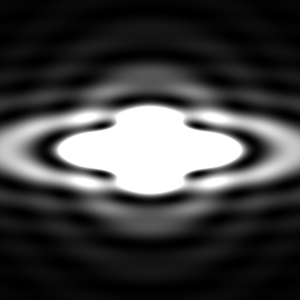

In [249]:
im = Image.fromarray(dif_pat * 255)
im.convert("L").resize((300, 300)) #real size is 1000 x 1000, resizing for comfortable view

In [250]:
#im.convert("L").save(dif_pat_name + ".png")

## Metropolis-Hastings

In [251]:
#In this symmetrical case we can use only 1/4 of data

buf = np.meshgrid(y_ar[:y_ar.shape[0]], x_ar[:x_ar.shape[0]])
x_data = tf.Variable(buf[1], dtype=float)
y_data = tf.Variable(buf[0], dtype=float)
I_data = tf.Variable(dif_pat[:dif_pat.shape[0], :dif_pat.shape[0]], dtype=float)

In [252]:
def transition_model(params, it, lr):
    p1, a1, b1, a2, b2, sigma = params
    scale = lr# * 10 ** -(it // 1000)
    p1_new = np.random.normal(loc=p1, scale=scale)
    
    a1_new = np.random.normal(loc=a1, scale=scale)
    b1_new = np.random.normal(loc=b1, scale=scale)
    
    a2_new = np.random.normal(loc=a2, scale=scale)
    b2_new = np.random.normal(loc=b2, scale=scale)
    sigma_new  = np.random.normal(loc=sigma, scale=scale)
    
    return np.array([p1_new, a1_new, b1_new, a2_new, b2_new, sigma_new])

In [253]:
#what we already know about parameters
def prior(params):
    p1, a1, b1, a2, b2, sigma = params
    if  sigma > 0 \
    and a1 > 0 \
    and b1 > 0 \
    and a2 > 0 \
    and b2 > 0 \
    and 0 < p1 <= 0.5\
    and  0.95 < a1 / b1 < 1.05\
    and 0.95 < (a2 * b2) / (a1 * b1) < 1.05:
        return True
    return False

In [254]:
#log likelihood function
#@tf.function
def loglike(params, x, y, ii, lmbda, z):
    p1, a1, b1, a2, b2, sigma = list(map(lambda x: tf.Variable(x, dtype=float), params))
    lp = prior(params)
    if not lp:
        return -np.inf
    else:
        p2 = 1 - p1
        return -tf.reduce_sum(tf.square(ii - I_tf(x,y, p1, a1, b1, p2, a2, b2, lmbda, z) )) / 2/(tf.square(sigma))-ii.shape[0]*ii.shape[1]*tf.math.log(sigma*tf.sqrt(2*tf.constant(np.pi)))

$$\log{\mathcal{L}} 
= \log{\prod\limits_{i, j=1}^N{f(I_{ij}|x_i, y_j,\lambda, z, \theta)}}=
-N^2\cdot\log{\sigma\sqrt{2\pi}} - \sum_{i=1}^N\sum_{j=1}^N{\frac{(I_{ij} - I(x_i, y_j, \lambda, z, \theta))^2}{2\sigma^2}}$$

In [255]:
#Decides whether new params better or not
def acceptance(params, params_new):
    if params_new > params:
        return True
    else:
        #return False
        accept=np.random.uniform(0,1)
        return (accept < (np.exp(params_new-params)))

In [256]:
def metropolis_hastings(likelihood, prior, transition_model, param_init, num_iterations, data, acceptance_rule, lr):
    params = param_init
    accepted = []
    rejected = []   
    all_params = []
    logs = []
    params_lik = None
    for i in tqdm(range(num_iterations)):
        params_new =  transition_model(params, i, lr)    
        if params_lik == None:
            params_lik = likelihood(params, *data)
        params_new_lik = likelihood(params_new, *data)
        logs.append(params_new_lik)
        if (acceptance_rule(params_lik,params_new_lik)):            
            params = params_new
            params_lik = params_new_lik
            accepted.append(params_new)
        else:
            rejected.append(params_new)   
        all_params.append(params)
    return np.array(accepted), np.array(rejected), np.array(all_params), np.array(logs)

In [257]:
NUM_ITERATIONS = 10_000
INIT_APPROX = [0.5, 1.0, 1.0, 1.0, 1.0 , 0.1]
LEARNING_RATE  = tf.constant(0.05)

In [258]:
accepted, rejected, all_pars, logs = metropolis_hastings(loglike,
                                         prior,
                                         transition_model,
                                         INIT_APPROX, 
                                         NUM_ITERATIONS,
                                         [x_data, y_data, I_data, tf.Variable(lmbda, dtype=float), tf.Variable(z, dtype=float)],
                                         acceptance, LEARNING_RATE)


100%|██████████| 10000/10000 [01:40<00:00, 99.75it/s]


In [259]:
#BEST OF THE BEST
accepted[-1]

array([0.29621, 4.02529, 4.00641, 8.00039, 1.99677, 0.02961])

In [260]:
accepted

array([[0.39956, 0.97368, 1.00911, 0.91936, 1.06911, 0.13252],
       [0.46244, 1.02245, 1.04883, 0.9345 , 1.1342 , 0.18691],
       [0.49232, 1.05099, 1.0011 , 0.88257, 1.22723, 0.22907],
       ...,
       [0.3082 , 4.03083, 3.98391, 8.03356, 1.99138, 0.03021],
       [0.29698, 4.02908, 3.99977, 8.00702, 1.99582, 0.01863],
       [0.29621, 4.02529, 4.00641, 8.00039, 1.99677, 0.02961]])

In [261]:
#REAL ONES
[p1, a1, b1, a2, b2]

[0.3, 4.0, 4.0, 8.0, 2.0]

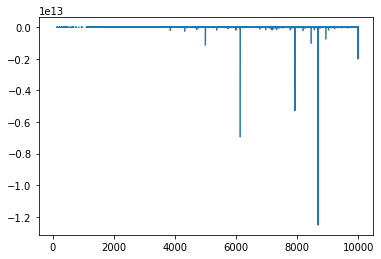

In [264]:
plt.plot(logs)


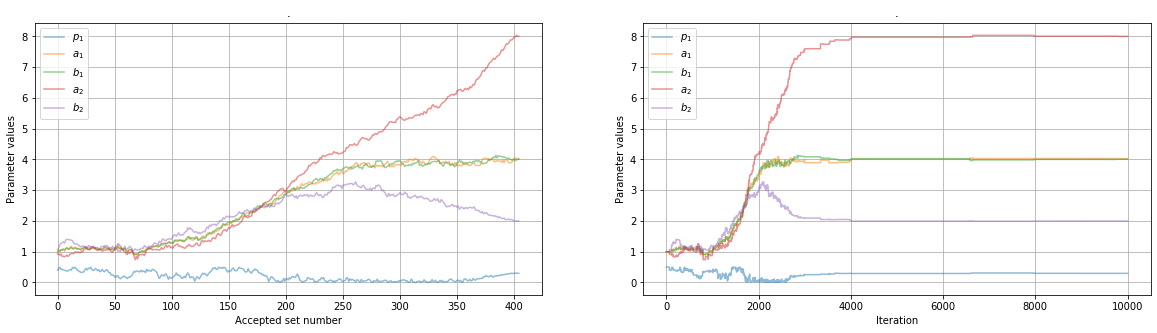

In [266]:
fig = plt.figure(figsize=(20,5))
ax2 = fig.add_subplot(1,2,1)
to_show=-accepted.shape[0]
ax2.plot( accepted[to_show:,0],  label='$p_1$',alpha=0.5)
ax2.plot( accepted[to_show:,1],  label='$a_1$',alpha=0.5)
ax2.plot( accepted[to_show:,2],  label='$b_1$',alpha=0.5)
ax2.plot( accepted[to_show:,3],  label='$a_2$',alpha=0.5)
ax2.plot( accepted[to_show:,4],  label='$b_2$',alpha=0.5)
ax2.set_xlabel("Accepted set number")
ax2.set_ylabel("Parameter values")
ax2.set_title(".")
ax2.grid()
ax2.legend()

ax3 = fig.add_subplot(1,2,2)
to_show=-all_pars.shape[0]
ax3.plot( all_pars[to_show:,0],  label='$p_1$',alpha=0.5)
ax3.plot( all_pars[to_show:,1],  label='$a_1$',alpha=0.5)
ax3.plot( all_pars[to_show:,2],  label='$b_1$',alpha=0.5)
ax3.plot( all_pars[to_show:,3],  label='$a_2$',alpha=0.5)
ax3.plot( all_pars[to_show:,4],  label='$b_2$',alpha=0.5)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Parameter values")
ax3.set_title(".")
ax3.grid()
ax3.legend()
